# Article Page Views

### Import Required Packages

In [1]:
# standard python packages 
import json, time, urllib.parse
import requests

# packages for data manipulation
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime

# packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.rcParams["figure.figsize"] = (26,12)

# package to ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

In [2]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<vpragya@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

In [3]:
# importing the dinosaurs name list
dinosaur = pd.read_excel('dinosaur_name.xlsx')

In [4]:
# replacing all the spaces in names with '_' for dinosaur with two word names
dinosaur['name'] = dinosaur['name'].apply(lambda x: x.replace(" ", "_"))
dinosaur.head()

,name,url
0,"""Coelosaurus""_antiquus",https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


In [5]:
# list of Dinosaur Wikipedia article titles
ARTICLE_TITLES = dinosaur['name'].tolist()

In [6]:
# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",     
    "agent":       "user",
    "article":     "",         
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"   
}

In [7]:
def request_pageviews_per_article(article_title = None, 
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None

    # Make sure we have an article title
    if not access_type: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [8]:
# fetching all the views for the desktop data
views_desktop = []
for i in range(len(ARTICLE_TITLES)):
    views = request_pageviews_per_article(ARTICLE_TITLES[i], "desktop")
    views_desktop.extend(views['items'])

# converting the list to dataframe
df_desktop = pd.DataFrame(views_desktop)

In [9]:
# fetching all the views for the mobile app data
views_mobile_app = []
for i in range(len(ARTICLE_TITLES)):
    views = request_pageviews_per_article(ARTICLE_TITLES[i], "mobile-app")
    views_mobile_app.extend(views['items'])

# converting the list to dataframe
df_mobile_app = pd.DataFrame(views_mobile_app)

In [10]:
# fetching all the views for the mobile web data
views_mobile_web = []
for i in range(len(ARTICLE_TITLES)):
    views = request_pageviews_per_article(ARTICLE_TITLES[i], "mobile-web")
    views_mobile_web.extend(views['items'])

# converting the list to dataframe
df_mobile_web = pd.DataFrame(views_mobile_web)

In [11]:
# removing access columns from all the data frames
df_desktop = df_desktop.drop(columns=['access'])
df_mobile_app = df_mobile_app.drop(columns=['access'])
df_mobile_web = df_mobile_web.drop(columns=['access'])

### Monthly desktop access

In [12]:
df_desktop.to_json('./output_data/dino_monthly_desktop_{}-{}.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'], ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end']), orient="records", indent=4)

### Monthly mobile access

In [13]:
df_mobile_app.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,0
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,7
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,7
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,12
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,5


In [14]:
df_mobile_web.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,5
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,48
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,44
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,58
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,49


In [15]:
df_mobile = df_mobile_app.copy()
df_mobile['views'] = df_mobile_app['views'] + df_mobile_web['views']
df_mobile.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,5
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,55
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,51
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,70
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,54


In [16]:
df_mobile.to_json('./output_data/dino_monthly_mobile_{}-{}.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'], ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end']), orient="records", indent=4)

### Monthly cumulative

In [17]:
combined_df = df_desktop.copy()
combined_df['views'] = combined_df['views'] + df_mobile['views']

In [18]:
combined_df['cumsum'] = combined_df.groupby(['article'])['views'].cumsum()

In [19]:
combined_df.head()

,project,article,granularity,timestamp,agent,views,cumsum
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,53,53
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,206,259
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,237,496
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,231,727
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,219,946


In [20]:
combined_df.to_json('./output_data/dino_monthly_cumulative_{}-{}.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'], ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end']), orient="records", indent=4)

# Analysis

In [21]:
df_desktop['date'] = pd.to_datetime(df_desktop['timestamp'], format="%Y%m%d%H")
df_desktop.head()

,project,article,granularity,timestamp,agent,views,date
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,48,2021-11-01
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,151,2021-12-01
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,186,2022-01-01
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,161,2022-02-01
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,165,2022-03-01


In [22]:
df_mobile['date'] = pd.to_datetime(df_mobile['timestamp'], format="%Y%m%d%H")
df_mobile.head()

,project,article,granularity,timestamp,agent,views,date
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,5,2021-11-01
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,55,2021-12-01
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,51,2022-01-01
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,70,2022-02-01
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,54,2022-03-01


Text(0.5, 1.0, 'Maximum Average and Minimum Average')

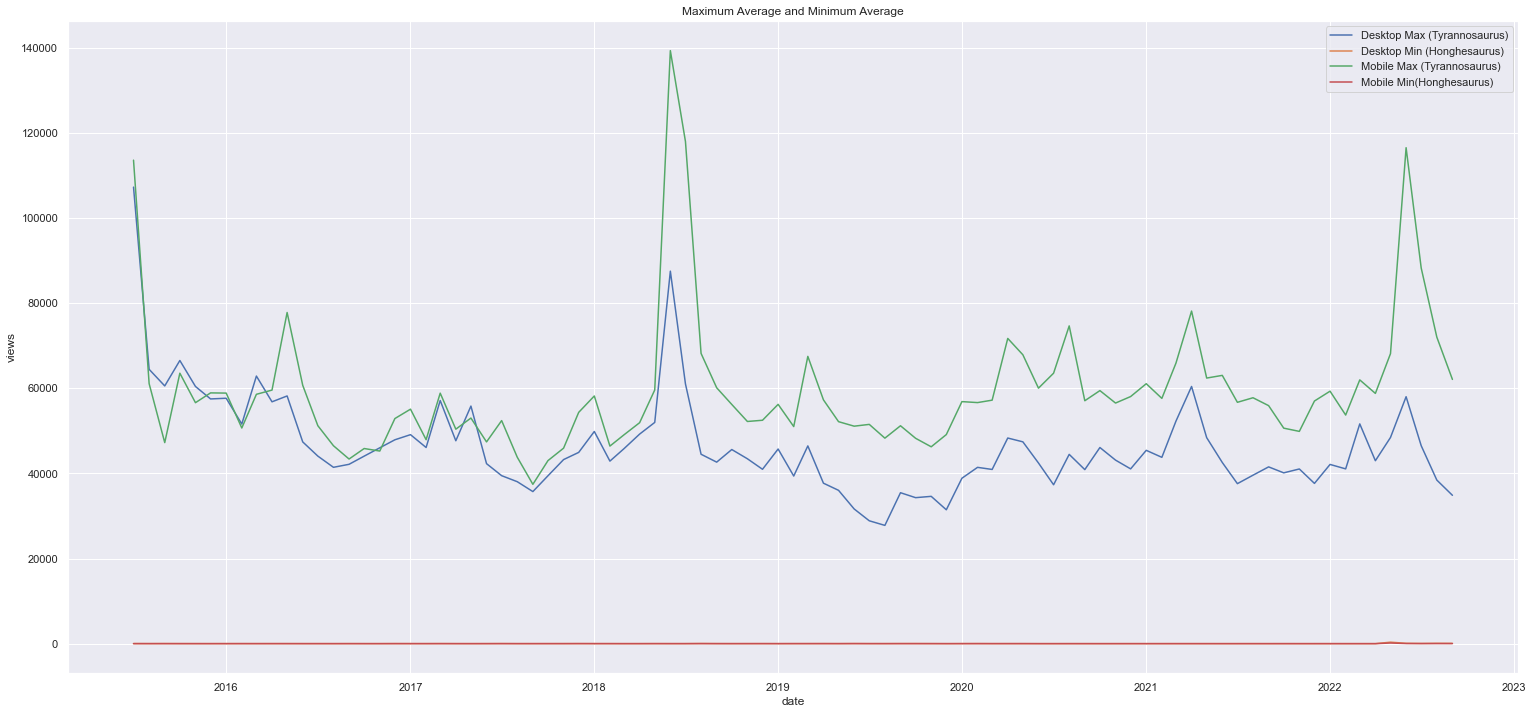

In [23]:
sns.lineplot(data = df_desktop.loc[df_desktop['article'] == df_desktop.groupby('article')['views'].mean().idxmax()], x = 'date', y='views')
sns.lineplot(data = df_desktop.loc[df_desktop['article'] == df_desktop.groupby('article')['views'].mean().idxmin()], x = 'date', y='views')
sns.lineplot(data = df_mobile.loc[df_mobile['article'] == df_mobile.groupby('article')['views'].mean().idxmax()], x = 'date', y='views')
sns.lineplot(data = df_mobile.loc[df_mobile['article'] == df_mobile.groupby('article')['views'].mean().idxmin()], x = 'date', y='views')
plt.legend(labels=['Desktop Max (Tyrannosaurus)', 'Desktop Min (Honghesaurus)', 'Mobile Max (Tyrannosaurus)', 'Mobile Min(Honghesaurus)'])
plt.title('Maximum Average and Minimum Average')

In [24]:
plt.savefig("./pic/Maximum Average and Minimum Average.png")

<Figure size 1872x864 with 0 Axes>

Text(0.5, 1.0, 'Top 10 Peak Page Views')

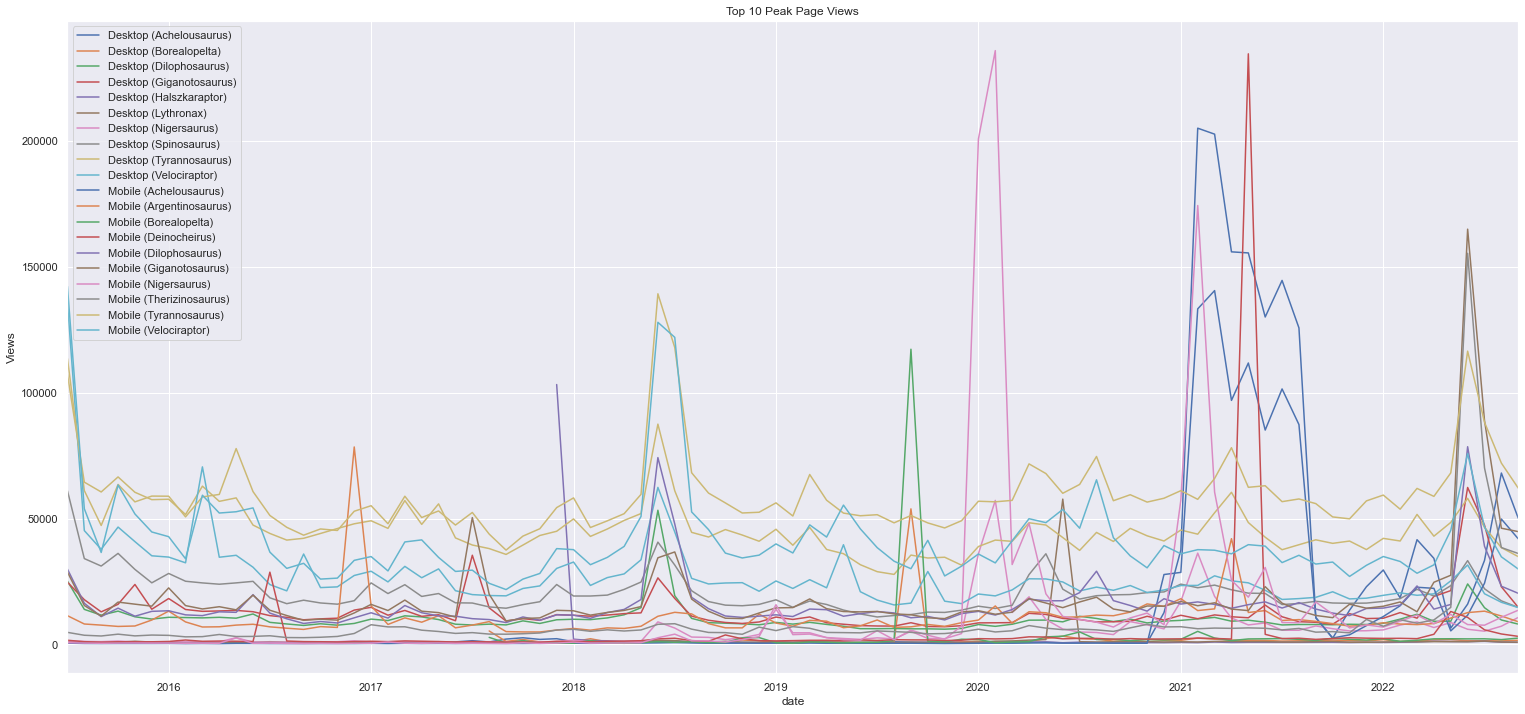

In [25]:
desktop_top_10 = df_desktop[df_desktop['article'].isin(df_desktop.groupby('article')['views'].max().nlargest(10).index)]
desktop_top_10['article'] = "Desktop (" + desktop_top_10['article'] + ")"

mobile_top_10 = df_mobile[df_mobile['article'].isin(df_mobile.groupby('article')['views'].max().nlargest(10).index)]
mobile_top_10['article'] = "Mobile (" + mobile_top_10['article'] + ")"

desktop_top_10.set_index('date', inplace=True)
mobile_top_10.set_index('date', inplace=True)

desktop_top_10.groupby('article')['views'].plot(legend=True)
mobile_top_10.groupby('article')['views'].plot(legend=True)

plt.ylabel("Views")
plt.title("Top 10 Peak Page Views")

In [26]:
plt.savefig("./pic/Top 10 Peak Page Views.png")

<Figure size 1872x864 with 0 Axes>

Text(0.5, 1.0, 'Fewest Months of Data')

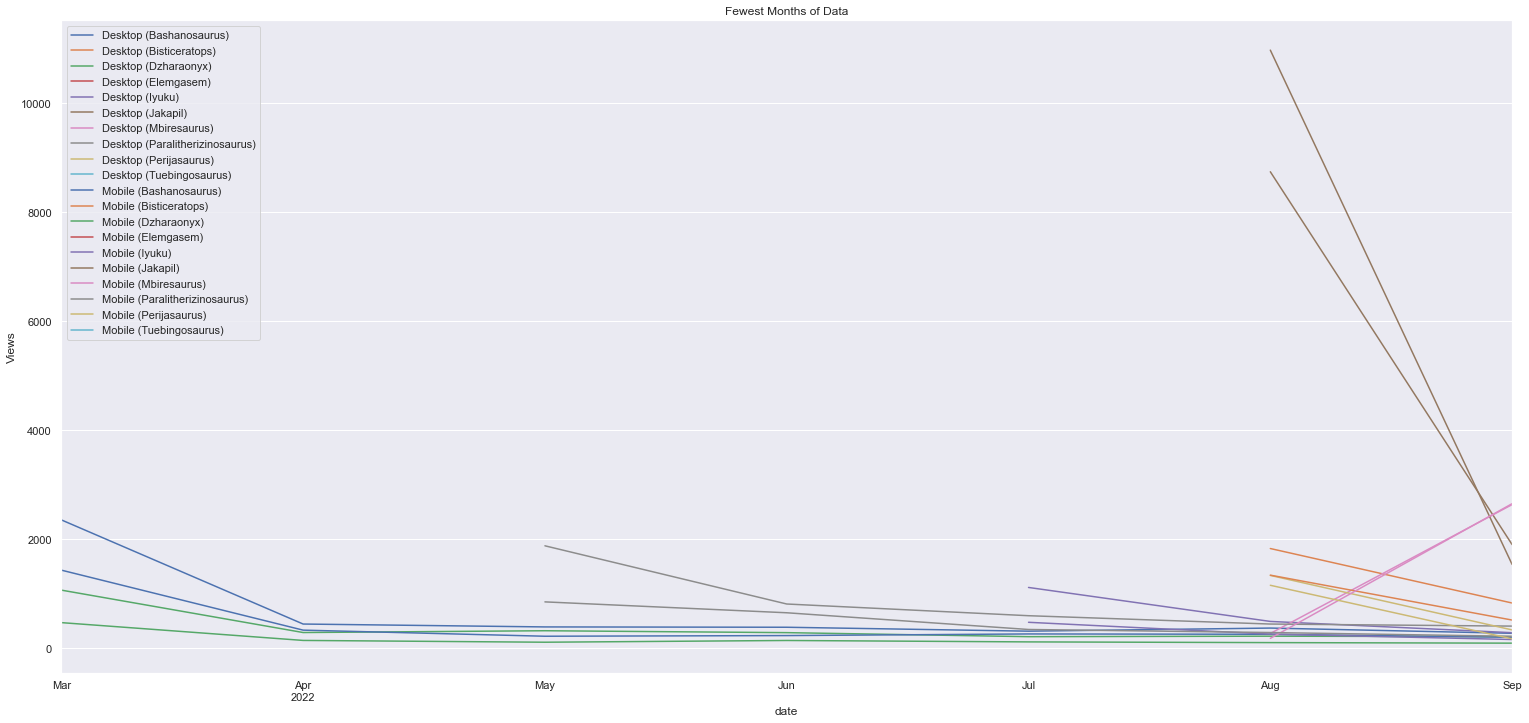

In [27]:
desktop_bottom_10 = df_desktop[df_desktop['article'].isin(df_desktop.groupby('article').size().nsmallest(10).index)]
desktop_bottom_10['article'] = "Desktop (" + desktop_bottom_10['article'] + ")"

mobile_bottom_10 = df_mobile[df_mobile['article'].isin(df_mobile.groupby('article').size().nsmallest(10).index)]
mobile_bottom_10['article'] = "Mobile (" + mobile_bottom_10['article'] + ")"

desktop_bottom_10.set_index('date', inplace=True)
mobile_bottom_10.set_index('date', inplace=True)

desktop_bottom_10.groupby('article')['views'].plot(legend=True)
mobile_bottom_10.groupby('article')['views'].plot(legend=True)

plt.ylabel("Views")
plt.title("Fewest Months of Data")

In [28]:
plt.savefig("./pic/Fewest Months of Data.png")

<Figure size 1872x864 with 0 Axes>